In [1]:
# Some code below borrowed from Nahil Sobh

from scipy.io import loadmat
from sklearn import linear_model

!pip install nibabel
import nibabel as nib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

global_link = "/Users/tejaswirachapudi/AHIResearch/test"
!pip install pydicom
!ls $("/Users/tejaswirachapudi/AHIResearch/test/MRF_QC_4minutes_e9943_mr50_20200102")

/bin/sh: /Users/tejaswirachapudi/AHIResearch/test/MRF_QC_4minutes_e9943_mr50_20200102: is a directory
01_Explore_MRF (1).ipynb          Rotated_MRI_cube.npy
01_Explore_MRF.ipynb              V.npy
02_Explore_MRI (1).ipynb          X_complex.npy
02_Explore_MRI.ipynb              data
03_Explore_DICOM.ipynb            test
03_train_one_epoch.ipynb          test.tar
MRI_PCA.ipynb                     utilities_module.py
MRI_cube.npy                      voxel_to_voxel_linear_model.ipynb
PCA_Exploration (2).ipynb


In [2]:
dictmat =  global_link + "/MRF_QC_4minutes_e9943_mr50_20200102/dict.mat"
XC_file =  global_link + "/MRF_QC_4minutes_e9943_mr50_20200102/X_complex.nii"

In [3]:
dict = loadmat(dictmat)
dict.keys()
dict['dict'].dtype
D      = dict['dict']["D"]
V      = dict['dict']["V"]
lut    = dict['dict']["lut"]
d      = dict['dict']["d"]
method = dict['dict']["method"]

In [4]:
print("D      ",      D[0,0].shape )
print("V      ",      V[0,0].shape ) #we need this
print("lut    ",    lut[0,0].shape )
print("d      ",      d[0,0].shape )
print("method ", method[0,0].shape )

D       (47880, 533)
V       (533, 30)
lut     (47880, 2)
d       (1, 1)
method  (1, 1)


In [5]:
X_complex = np.array(nib.load(XC_file).dataobj) 
v         = V[0][0][:]

In [6]:
# size 30 MRF data

m=0
for i in range(0,256,64):
    for j in range(0,256,64):  
        for k in range(0,256,64):
            x  = X_complex[i, j, k, :] # at voxel i,j,k
#            print(x)
            y  = np.dot(v,x)
            
            yr = y.real
            yi = y.imag
            ya = abs(y)
            ijk= str(i) + " " + str(j) + " " + str(k)
#            print(ijk)


# Linear modeling work 

Author: Tejaswi Rachapudi

In [4]:
# -------------
# Get MRI data (256,256,256,7)
# ["PDw_au","syFLAIR","syFSE","syGRE","syMP2RAGE","T1","T2"]
# -------------
Rotated_MRI_cube = np.load("../AHIResearch/Rotated_MRI_cube.npy")


In [5]:
# -------------
# Get MRF Compressed data (256,256,256,30)
# Compressed MRF signal of size 30 (original length 533)
# -------------
X_complex = np.load("../AHIResearch/X_complex.npy")

In [6]:
# -------------
# Get V orthogonal Matrix (533,30) for de-compression (if needed)
# -------------
V      = np.load("../AHIResearch/V.npy")

In [7]:
# -------------
# Get the Amplitudes of MRI and Compressed MRF data Cubes
# -------------
abs_Rotated_MRI_cube = abs(Rotated_MRI_cube)
abs_X_complex        = abs(       X_complex)

In [8]:
#--------------------------
# A quick min and max over all samples
#--------------------------
MRI_min  = abs_Rotated_MRI_cube.min() ; MRI_max  = abs_Rotated_MRI_cube.max()
XMRF_min =        abs_X_complex.min() ; XMRF_max =        abs_X_complex.max()

z=(0, 255)
for i in range(7):
        dmax  = abs(Rotated_MRI_cube[:,:,z,i].max())
        dmin  = abs(Rotated_MRI_cube[:,:,z,i].min())
        print("MRI_min  ... ",  dmin )
        print("MRI_max  ... ",  dmax )

print()
print("XMRF_min ... ", XMRF_min )
print("XMRF_max ... ", XMRF_max )


MRI_min  ...  3.331512453438439e-12
MRI_max  ...  676.9999999999999
MRI_min  ...  18.999999999999986
MRI_max  ...  475.00000000000006
MRI_min  ...  1.7010299175933695e-12
MRI_max  ...  515.9999999999999
MRI_min  ...  6.591386020763785e-13
MRI_max  ...  461.00000000000006
MRI_min  ...  165.99999999999994
MRI_max  ...  751.0000000000003
MRI_min  ...  0.0
MRI_max  ...  3500.0000000000464
MRI_min  ...  0.0
MRI_max  ...  3000.0000000000455

XMRF_min ...  0.0
XMRF_max ...  0.00029269187


In [9]:
# ---------------------------------------------------------
# Pick a set (at random with replacement) 
# of MRI (input) and Compressed_MRF (output)
# --------------------------------------------------------
def get_XY (sample_size):
    
    # -----
    # Check if the requested size is available
    # -----
    if sample_size > 10**6 : # Here is the error if set can not be served
        print("You used a sample size =",sample_size )
        print("This is larger than the allowed size 10^6")
        sys.exit("Terminating the job :(")

    # ----------
    # Initialize set and while loop paramters then iterate the desired set size if found
    # ----------
    epsilon = 10**(-4)                   # Threshold below which a sample is not selected
    X       = np.zeros((sample_size, 7)) #            MRI stored in this array
    Y       = np.zeros((sample_size,30)) # Compressed MRF stored in this array
    
    found   = False
    items   = 0
    tried   = 0 
    ijk     = []
    
    while not found: 
        tried +=1
        i = np.random.randint(0,255)
        j = np.random.randint(0,255)
        k = np.random.randint(0,255)

        absX = abs_X_complex [i,j,k,:]   # get a compressed MRF signature

        if  sum(absX[1:]) > epsilon :   # There is an MRF siganl ... yay
            Y[items] = absX
            X[items] = abs_Rotated_MRI_cube [i,j,k,:]
            items += 1
            ijk.append([i,j,k])
            
        if  items > sample_size-1:    # Do we have enought samples to exit?
            found = True

    print( "How many samples did we check     . . . ", tried )
    print( "and what was the desired set size . . . ", items )
    
    return (X,Y,np.array(ijk))

In [180]:
X,Y,coord_train = get_XY(150000)

How many samples did we check     . . .  325136
and what was the desired set size . . .  150000


In [181]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [182]:
print(x_train[0])

[491. 489. 506. 394. 678. 770.  37.]


In [183]:
print(y_train[0])

[2.76123883e-05 8.32942533e-06 9.52836308e-06 2.73371643e-06
 1.55821976e-06 6.16343414e-06 3.20446361e-06 4.42197779e-06
 2.98720624e-06 6.97579208e-06 9.36835204e-06 7.05887430e-07
 5.25644646e-06 6.49693584e-06 6.78367223e-06 7.18933325e-06
 1.63488414e-06 6.82734571e-06 4.23934534e-06 3.65232017e-06
 4.00661929e-06 5.53077052e-06 3.81471000e-06 7.26948883e-06
 3.09916641e-06 2.39745600e-06 2.15874070e-06 2.37308245e-06
 7.01844783e-06 2.44520402e-06]


In [184]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
print(regr.coef_)

[[-2.15393398e-08 -5.89416004e-10  2.12469663e-08  6.91404286e-08
   1.04581406e-08  8.67312778e-10 -1.24825280e-09]
 [-9.94897057e-09 -1.49123015e-08  1.38693243e-08  2.54333669e-08
   5.00006598e-09  4.42504032e-10 -8.82074280e-10]
 [ 8.68457383e-09 -8.14429392e-10 -1.93143296e-09  1.30020818e-08
  -8.91428415e-10  1.25060558e-10  4.74019678e-10]
 [ 1.70438462e-09 -3.36694470e-09  2.08025968e-09 -2.50490575e-09
   1.88522225e-09  1.87206171e-11  7.62288316e-11]
 [ 1.78585284e-09 -4.01719676e-10 -7.81183160e-10  1.35528617e-10
  -1.30736033e-09  8.80577121e-11  1.84939216e-10]
 [ 1.72761355e-10 -2.36498172e-10 -6.46435634e-10 -1.06546680e-09
  -2.54633097e-10  1.43670616e-10  5.47858544e-11]
 [ 4.10876857e-10 -8.05018793e-11 -7.26219796e-10 -9.27082625e-10
  -4.71149177e-10  4.91033018e-11  3.81573010e-11]
 [-3.91239974e-10  1.91364379e-10 -2.78730203e-10  1.59131571e-09
  -4.76660821e-10  9.60663439e-12 -1.21303631e-11]
 [-1.29817273e-10  4.71888005e-11 -8.16292320e-10 -1.74335159e-1

In [185]:
y_pred = regr.predict(x_test)
print(y_pred)

[[6.06472590e-06 3.20468318e-06 3.50040237e-06 ... 5.02799914e-06
  5.96096349e-06 5.14230416e-06]
 [6.10950136e-06 5.29202776e-06 3.41735263e-06 ... 4.62296699e-06
  5.30201800e-06 4.62624168e-06]
 [1.50357033e-07 1.76441754e-06 3.07936031e-06 ... 4.73004073e-06
  5.39254452e-06 4.83364691e-06]
 ...
 [2.82921166e-06 2.34412335e-06 2.81219125e-06 ... 4.96092457e-06
  5.80539345e-06 5.09106293e-06]
 [2.39869775e-05 1.04543319e-05 6.23325681e-06 ... 5.69143476e-06
  7.14165585e-06 5.72614861e-06]
 [1.05093750e-05 1.51891720e-06 3.44311782e-06 ... 5.01198626e-06
  5.88911363e-06 5.09678254e-06]]


In [186]:
print(y_pred[0])

[6.06472590e-06 3.20468318e-06 3.50040237e-06 3.16079533e-06
 3.50280563e-06 4.23575251e-06 4.23243168e-06 3.70366277e-06
 5.62854727e-06 4.14884801e-06 5.70727192e-06 4.74644837e-06
 4.55015094e-06 5.87400015e-06 3.21576005e-06 5.29917450e-06
 5.68807998e-06 4.89139170e-06 4.23379317e-06 6.25553485e-06
 5.88172650e-06 5.65810904e-06 4.19287277e-06 5.03759562e-06
 4.20393238e-06 3.95303330e-06 3.40643299e-06 5.02799914e-06
 5.96096349e-06 5.14230416e-06]


In [187]:
print(y_test[0])

[6.47396746e-06 3.83971565e-06 4.97859946e-06 6.19622142e-06
 6.13628617e-06 7.04421609e-06 2.34496747e-06 2.27352621e-06
 4.09070481e-06 1.85383249e-06 3.74531987e-06 8.34585933e-07
 3.47177524e-06 1.82804331e-06 2.92291543e-06 7.77973401e-06
 4.00029239e-06 8.27841745e-07 2.04537560e-06 4.99315820e-06
 7.91942966e-06 9.49634250e-06 3.54845929e-06 2.67710129e-06
 9.62356262e-06 4.04381944e-06 4.75733395e-06 1.70109365e-06
 7.19048967e-06 5.96071777e-06]


In [188]:
import sklearn
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(y_test, y_pred))  # absolute residual at every point, then average
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(y_test, y_pred))  # average of squared difference between actual and predicted 
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.2206208302433377e-06
Mean Squared Error: 9.821965719352345e-12
Root Mean Squared Error: 3.1340015506301755e-06


In [189]:
regr.score(x_test, y_test)

0.6377159149250344

In [190]:
df = pd.DataFrame({'Actual': y_test[0], 'Predicted': y_pred[0]})

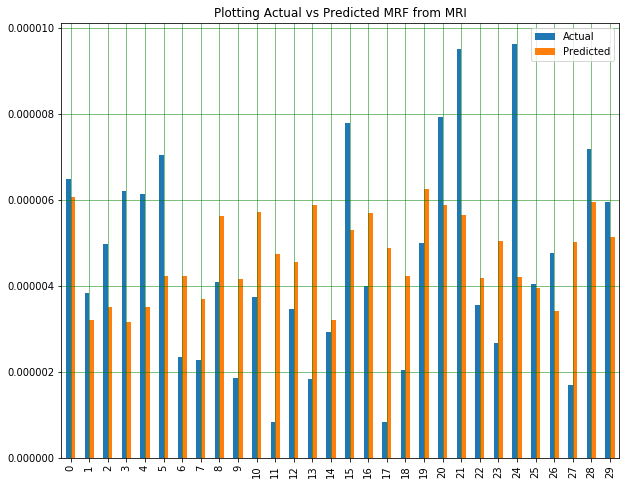

In [191]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Plotting Actual vs Predicted MRF from MRI')
plt.show()

MRF to MRI

In [192]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Y, X, test_size = 0.2)

In [193]:
print(x_train[0])

[5.41642021e-06 3.01028990e-06 5.73057150e-06 4.42627334e-06
 9.77327272e-06 8.67455947e-06 2.36631263e-06 2.39971769e-06
 2.57147212e-06 1.92920470e-06 4.58105796e-06 3.48269486e-06
 4.55107147e-06 3.54099893e-06 1.19491824e-06 4.03022887e-06
 4.58878003e-06 2.65023482e-06 9.37559616e-06 2.55755663e-06
 3.34764559e-06 8.69362964e-07 5.57757039e-06 9.11942607e-06
 9.67057167e-06 1.43680472e-06 3.74035335e-06 6.41891756e-06
 4.89031720e-07 5.36201333e-06]


In [194]:
print(y_train[0])

[1.18000000e+02 6.50000000e+01 1.27000000e+02 1.60000000e+01
 1.60159691e-12 2.15000000e+03 1.90000000e+02]


In [195]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
print(regr.coef_)

[[ 1.09585776e+07 -2.39492639e+07  2.61702565e+07  1.14838372e+07
   1.21584036e+06 -3.20372438e+06 -7.03156772e+05 -6.55161848e+05
  -1.86109298e+06 -5.73771918e+05 -1.55914738e+06 -3.72973450e+05
  -1.00578702e+06 -1.83365602e+05  1.10163522e+06 -5.60392140e+05
  -5.50383391e+05 -8.18077867e+05 -2.46705277e+05  3.68752403e+05
  -6.80625622e+05 -6.84676617e+05 -1.03043930e+06 -4.31043275e+05
  -1.19721444e+06 -1.65058809e+06 -8.31727862e+05 -5.88064381e+05
  -1.17431474e+06 -1.26799934e+06]
 [ 2.56631438e+07 -5.46586435e+07  7.18137535e+06  8.09455961e+06
  -3.62685339e+06 -2.31988288e+06 -1.32479081e+06 -8.74378415e+05
  -1.63679797e+06 -2.01002794e+04 -1.29591763e+06 -6.47567962e+05
  -6.68037386e+05 -9.45126517e+05  8.96654787e+05 -7.97262422e+05
  -1.23760352e+06 -2.41755422e+05 -1.22985629e+05 -9.86249951e+05
  -4.37570893e+05 -6.73543074e+05 -4.17602013e+05 -1.59542587e+05
   9.18994990e+04 -1.36665853e+06 -7.71281391e+05 -2.14592037e+05
  -9.14565578e+05 -1.04826874e+06]
 [ 2.1

In [196]:
y_pred = regr.predict(x_test)
print(y_pred)

[[ 333.77882013  129.42451999  761.13447385 ...  553.41958307
   749.66937505  129.80366478]
 [ 667.12271494  717.71224162  965.51773988 ...  750.8849646
  1038.39061532  227.16080392]
 [ 249.2557172   418.85472141  594.36954468 ...  419.3669875
   517.21471718  356.68957541]
 ...
 [  95.46881969 -102.01821769  -82.87544076 ...   21.95989712
  1808.82710173  871.79120244]
 [ 104.58392281  -91.13978686  161.18479003 ...   51.36891319
  1712.77060505  629.42593322]
 [ 512.49759966  737.03985344  677.22277746 ...  553.90591658
   978.68315578  427.34525678]]


In [197]:
print(y_pred[0])

[333.77882013 129.42451999 761.13447385 527.70342848 553.41958307
 749.66937505 129.80366478]


In [198]:
print(y_test[0])

[1.76000000e+02 5.04762507e-14 4.38000000e+02 6.30000000e+02
 3.94000000e+02 7.00000000e+01 1.15000000e+02]


In [199]:
regr.score(x_test, y_test)

0.20209938493977217

In [200]:
df = pd.DataFrame({'Actual': y_test[0], 'Predicted': y_pred[0]})

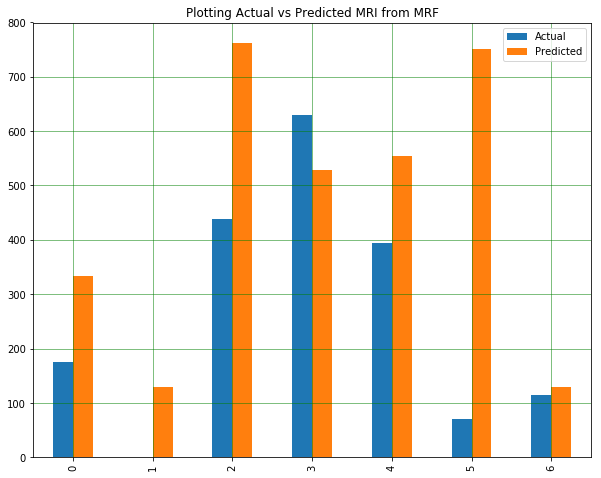

In [201]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Plotting Actual vs Predicted MRI from MRF')
plt.show()

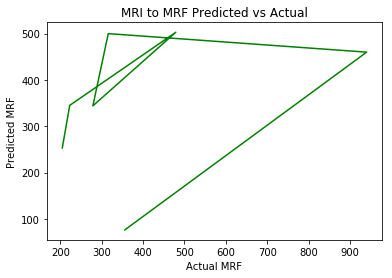

In [105]:
plt.plot(y_pred[0], y_test[0], color = "green")
plt.title("MRI to MRF Predicted vs Actual")
plt.xlabel("Actual MRF")
plt.ylabel("Predicted MRF")
plt.show()

Scaling Attempts

In [38]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerX.fit(x_train)
scalerX.mean_

array([ 215.090675 ,  180.7727125,  296.953425 ,  179.1716   ,
        229.7668875, 1278.544125 ,  520.457925 ])

In [39]:
trans_x_train = scalerX.transform(x_train)
print(trans_x_train[0])

[-0.46517661 -0.57277377 -0.70905933 -0.73500869 -0.69162969 -0.70859574
 -0.50265899]


In [40]:
scalerY = StandardScaler()
scalerY.fit(y_train)
scalerY.mean_

array([1.59075512e-05, 6.25289815e-06, 4.98723472e-06, 3.34390550e-06,
       3.48320820e-06, 4.05897101e-06, 4.00121731e-06, 3.72633296e-06,
       5.46669826e-06, 4.28020481e-06, 5.89894372e-06, 4.79312915e-06,
       4.46753756e-06, 5.79431528e-06, 3.20448554e-06, 5.26504518e-06,
       5.68175145e-06, 4.88872224e-06, 4.29928686e-06, 6.00537222e-06,
       6.02266267e-06, 5.72956808e-06, 4.32331160e-06, 5.12161191e-06,
       4.25147679e-06, 4.10759052e-06, 3.43874473e-06, 5.08378479e-06,
       6.10817241e-06, 5.10320051e-06])

In [41]:
trans_y_train = scalerY.transform(y_train)
print(trans_y_train[0])

[-0.50038274 -0.33168343 -0.81058823  1.29588988 -0.62029009 -0.27117799
  0.3676153   2.01072149  0.00334134  0.22419189  0.07925678 -0.29091071
  0.02395433  0.96391831 -1.09286342 -1.06184329 -0.58786248 -1.3896858
 -1.32040862 -0.42111245 -0.99741697 -0.54440301  0.01379035 -0.45885328
  0.31595119 -1.32634667  0.64550209 -0.13217804  0.11733143  0.01112608]


In [42]:
trans_x_test = scalerX.transform(x_test)
y_pred = regr.predict(trans_x_test)
print(y_pred)

[[-7.12417507e-07  1.19623063e-06  1.39043917e-06 ...  5.01855008e-06
   5.84773459e-06  5.20691379e-06]
 [-9.56290964e-07  1.11689483e-06  1.35201396e-06 ...  5.01340536e-06
   5.83672182e-06  5.20320452e-06]
 [-9.33312251e-07  1.12346524e-06  1.34772425e-06 ...  5.01446672e-06
   5.83898729e-06  5.20446506e-06]
 ...
 [-8.96882067e-07  1.14008708e-06  1.35315566e-06 ...  5.01559450e-06
   5.84108151e-06  5.20534612e-06]
 [-9.45182838e-07  1.11975304e-06  1.35155491e-06 ...  5.01403775e-06
   5.83795350e-06  5.20390970e-06]
 [-9.09934794e-07  1.13455005e-06  1.35110198e-06 ...  5.01548822e-06
   5.84077568e-06  5.20532965e-06]]


In [43]:
trans_y_test = scalerY.transform(y_test)

In [44]:
regr.score(trans_x_test, trans_y_test)

-7.591320179390463e-05

In [85]:
import sklearn
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(y_test, y_pred))  # absolute residual at every point, then average
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(y_test, y_pred))  # average of squared difference between actual and predicted 
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.8326333737534058e-06
Mean Squared Error: 3.846941105970454e-11
Root Mean Squared Error: 6.202371406140118e-06


In [53]:
from sklearn.preprocessing import MinMaxScaler
scalerX = MinMaxScaler()
scalerX.fit(x_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [54]:
trans_x_train = scalerX.transform(x_train)
print(trans_x_train[0])

[2.91725105e-02 6.05504131e-17 2.86536507e-16 6.80713128e-03
 8.69304556e-03 1.17142857e-01 3.33333333e-03]


In [55]:
scalerY = MinMaxScaler()
scalerY.fit(y_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [56]:
trans_y_train = scalerY.transform(y_train)
print(trans_y_train[0])

[0.02166196 0.04396473 0.02960554 0.26606364 0.13201964 0.13388434
 0.23342453 0.37698286 0.19879688 0.21265275 0.18520892 0.15328225
 0.19513297 0.29159885 0.07515531 0.06212718 0.13698123 0.02731353
 0.03602607 0.13706837 0.05659217 0.11297733 0.13559595 0.12539315
 0.21205485 0.03031581 0.24167685 0.1680609  0.16971969 0.1733527 ]


In [57]:
trans_x_test = scalerX.transform(x_test)
y_pred = regr.predict(trans_x_test)
print(y_pred)

[[-8.68896346e-07  1.14389642e-06  1.36311572e-06 ...  5.01537480e-06
   5.84093927e-06  5.20477785e-06]
 [-8.87211136e-07  1.13773102e-06  1.36069835e-06 ...  5.01503060e-06
   5.84013501e-06  5.20452116e-06]
 [-8.87235497e-07  1.13715938e-06  1.36070337e-06 ...  5.01506823e-06
   5.84021080e-06  5.20459682e-06]
 ...
 [-8.84677900e-07  1.13836038e-06  1.36106844e-06 ...  5.01514641e-06
   5.84035854e-06  5.20465926e-06]
 [-8.86989825e-07  1.13763073e-06  1.36062315e-06 ...  5.01508473e-06
   5.84023443e-06  5.20459724e-06]
 [-8.84822495e-07  1.13852370e-06  1.36057952e-06 ...  5.01518928e-06
   5.84043469e-06  5.20470779e-06]]


In [58]:
trans_y_test = scalerY.transform(y_test)

In [59]:
regr.score(trans_x_test, trans_y_test)

-2.6959680670514645